<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li></ul></div>

# Introduction

* Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

* First, load the dataset.

# Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.stats.stats import ttest_ind
from sqlalchemy import create_engine
import warnings
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 150
pd.options.display.max_rows = 150

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

In [3]:
for col in life_df.columns:
    new_col = col.strip().lower().replace(' ', '_').replace('-', '_')
    life_df[new_col] = life_df[col]
    life_df.drop(col, axis=1, inplace=True)

In [4]:
life_df

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness__1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
5,Afghanistan,2010,Developing,58.8,279.0,74,0.01,79.679367,66.0,1989,16.7,102,66.0,9.20,66.0,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2
6,Afghanistan,2009,Developing,58.6,281.0,77,0.01,56.762217,63.0,2861,16.2,106,63.0,9.42,63.0,0.1,445.893298,284331.0,18.6,18.7,0.434,8.9
7,Afghanistan,2008,Developing,58.1,287.0,80,0.03,25.873925,64.0,1599,15.7,110,64.0,8.33,64.0,0.1,373.361116,2729431.0,18.8,18.9,0.433,8.7
8,Afghanistan,2007,Developing,57.5,295.0,82,0.02,10.910156,63.0,1141,15.2,113,63.0,6.73,63.0,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4
9,Afghanistan,2006,Developing,57.3,295.0,84,0.03,17.171518,64.0,1990,14.7,116,58.0,7.43,58.0,0.1,272.563770,2589345.0,19.2,19.3,0.405,8.1


* Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them. 

In [5]:
life_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
country                            2938 non-null object
year                               2938 non-null int64
status                             2938 non-null object
life_expectancy                    2928 non-null float64
adult_mortality                    2928 non-null float64
infant_deaths                      2938 non-null int64
alcohol                            2744 non-null float64
percentage_expenditure             2938 non-null float64
hepatitis_b                        2385 non-null float64
measles                            2938 non-null int64
bmi                                2904 non-null float64
under_five_deaths                  2938 non-null int64
polio                              2919 non-null float64
total_expenditure                  2712 non-null float64
diphtheria                         2919 non-null float64
hiv/aids                           2938 non-null

Data type is mostly continous value base upon time series

In [6]:
# pct of nulls in each feature
life_df.isnull().sum()*100 / life_df.isnull().count()

country                             0.000000
year                                0.000000
status                              0.000000
life_expectancy                     0.340368
adult_mortality                     0.340368
infant_deaths                       0.000000
alcohol                             6.603131
percentage_expenditure              0.000000
hepatitis_b                        18.822328
measles                             0.000000
bmi                                 1.157250
under_five_deaths                   0.000000
polio                               0.646698
total_expenditure                   7.692308
diphtheria                          0.646698
hiv/aids                            0.000000
gdp                                15.248468
population                         22.191967
thinness__1_19_years                1.157250
thinness_5_9_years                  1.157250
income_composition_of_resources     5.684139
schooling                           5.547992
dtype: flo

In [7]:
unique_country = life_df.country.unique()
fill_col = life_df.columns[3:]

#fill nans with linear interpolation since data is ordered by time series (year)
for country in unique_country:
    life_df.loc[life_df['country'] == country,fill_col] = life_df.loc[life_df['country'] == country,fill_col].interpolate()
    
life_df.dropna(inplace=True)

In [8]:
life_df.isnull().sum()*100 / life_df.isnull().count()

country                            0.0
year                               0.0
status                             0.0
life_expectancy                    0.0
adult_mortality                    0.0
infant_deaths                      0.0
alcohol                            0.0
percentage_expenditure             0.0
hepatitis_b                        0.0
measles                            0.0
bmi                                0.0
under_five_deaths                  0.0
polio                              0.0
total_expenditure                  0.0
diphtheria                         0.0
hiv/aids                           0.0
gdp                                0.0
population                         0.0
thinness__1_19_years               0.0
thinness_5_9_years                 0.0
income_composition_of_resources    0.0
schooling                          0.0
dtype: float64

In [9]:
(len(fill_col)+1)//4

5

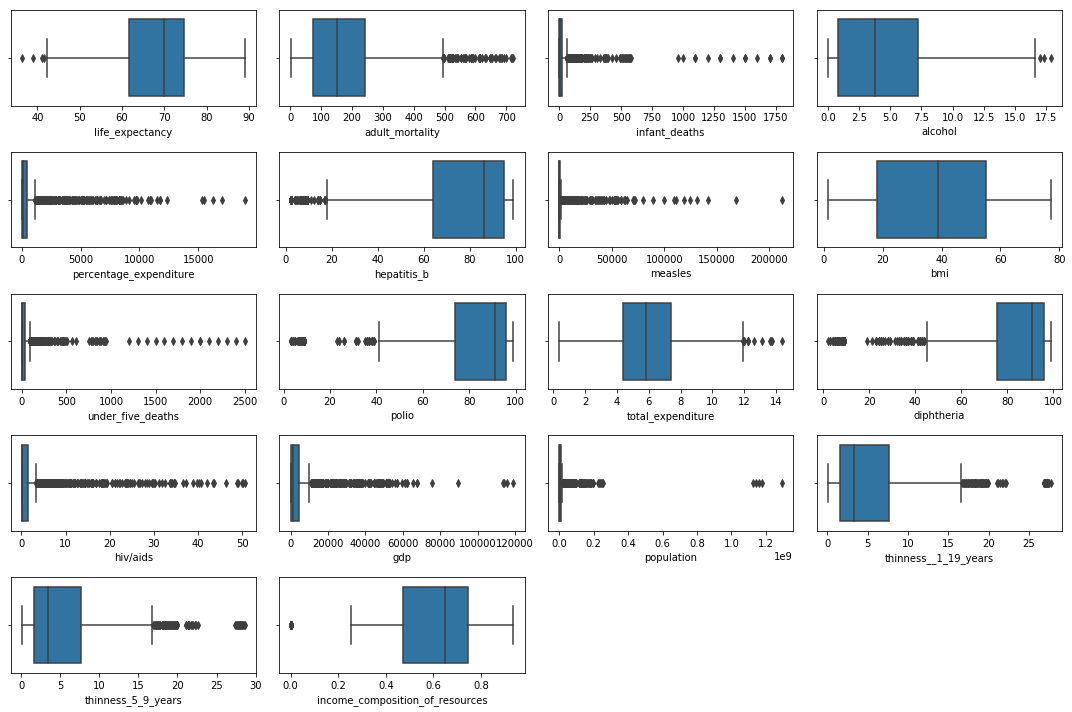

In [10]:
plt.figure(figsize=(15,10))
for num in range(1,len(fill_col)):
    plt.subplot((len(fill_col)+1)//4,4,num)
    sns.boxplot(life_df[fill_col[num-1]])
    plt.tight_layout()

In [11]:
clean_df = life_df.copy()

Feature: life_expectancy ... outliers: 4 ... percentage 0.20130850528434827


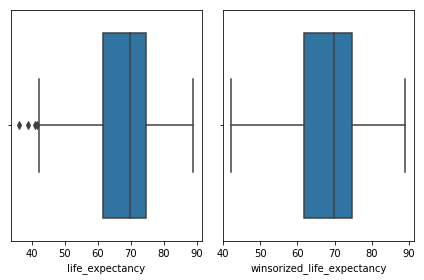

Feature: adult_mortality ... outliers: 58 ... percentage 2.9189733266230498


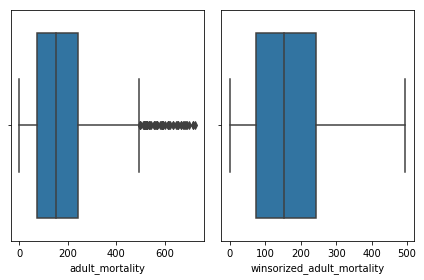

Feature: infant_deaths ... outliers: 198 ... percentage 9.96477101157524


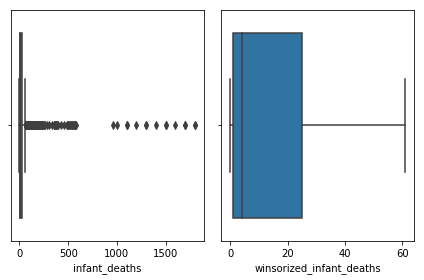

Feature: alcohol ... outliers: 3 ... percentage 0.1509813789632612


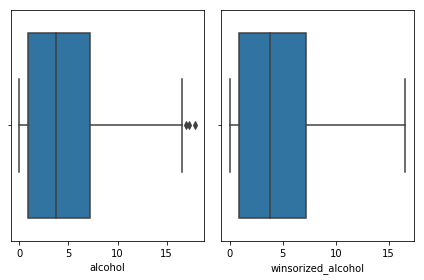

Feature: percentage_expenditure ... outliers: 232 ... percentage 11.675893306492199


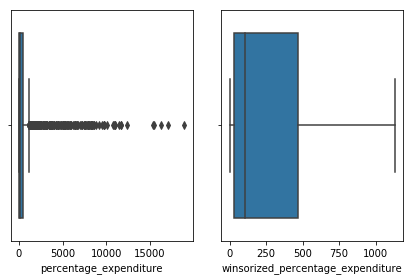

Feature: hepatitis_b ... outliers: 216 ... percentage 10.870659285354806


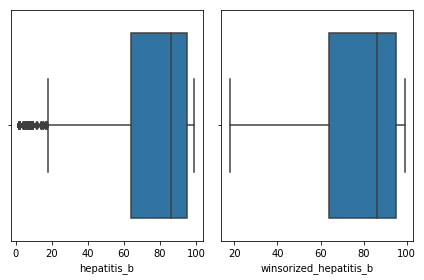

Feature: measles ... outliers: 361 ... percentage 18.16809260191243


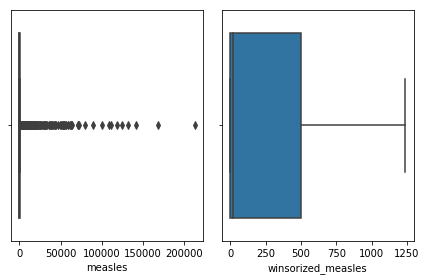

Feature: bmi ... outliers: 0 ... percentage 0.0


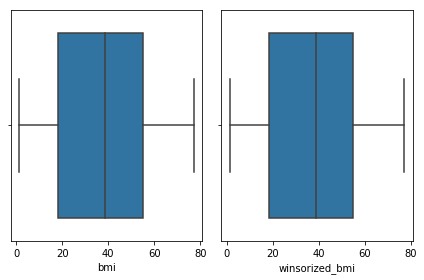

Feature: under_five_deaths ... outliers: 227 ... percentage 11.424257674886764


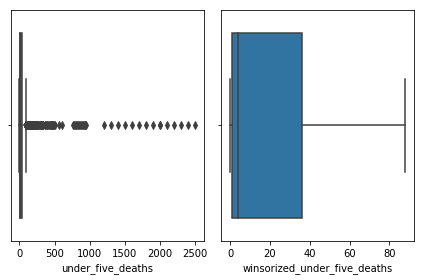

Feature: polio ... outliers: 159 ... percentage 8.002013085052843


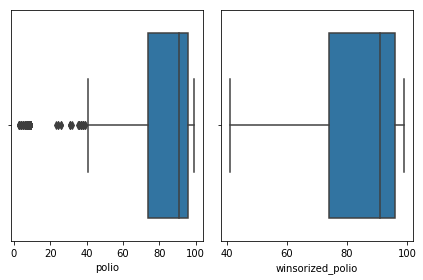

Feature: total_expenditure ... outliers: 13 ... percentage 0.6542526421741319


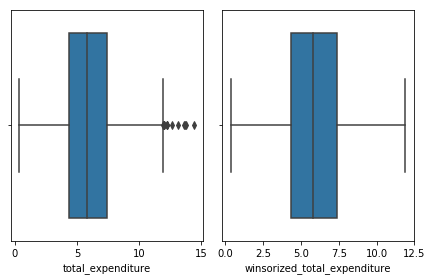

Feature: diphtheria ... outliers: 195 ... percentage 9.813789632611977


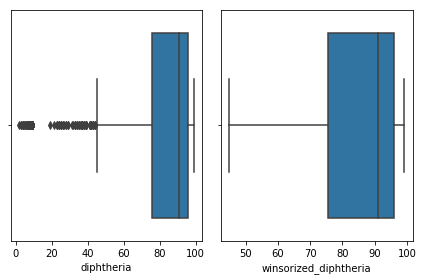

Feature: hiv/aids ... outliers: 309 ... percentage 15.551082033215904


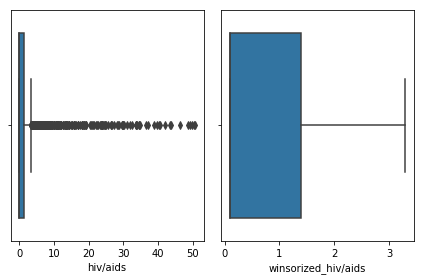

Feature: gdp ... outliers: 244 ... percentage 12.279818822345243


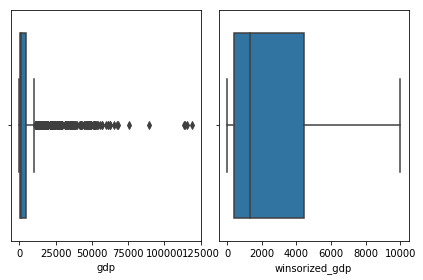

Feature: population ... outliers: 260 ... percentage 13.085052843482636


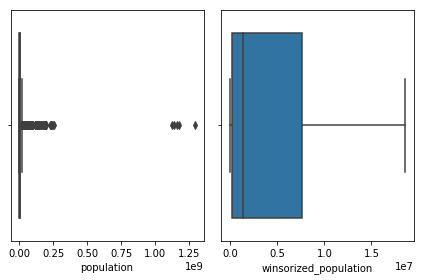

Feature: thinness__1_19_years ... outliers: 70 ... percentage 3.5228988424760943


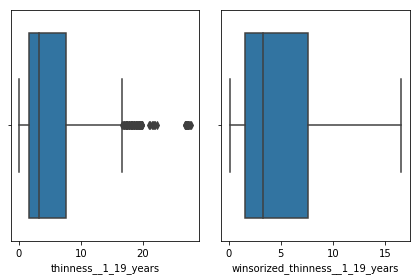

Feature: thinness_5_9_years ... outliers: 75 ... percentage 3.7745344740815296


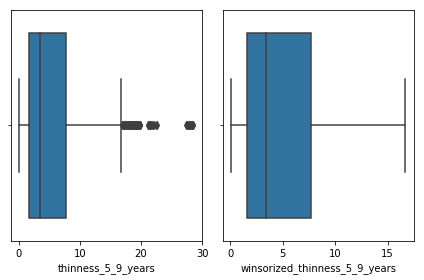

Feature: income_composition_of_resources ... outliers: 91 ... percentage 4.579768495218923


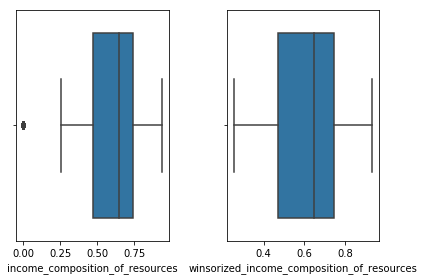

In [12]:
# turkey method to find outliers and it's pct within feature. Use pct as parameter for winsorized method for both min and max

for num in range(1, len(fill_col)):
    q25, q75 = np.percentile(life_df[fill_col[num-1]], [25,75])
    iqr = q75 - q25
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    
    min_outliers, max_outliers = len(np.where(life_df[fill_col[num-1]] < min_val)[0]), len(np.where(life_df[fill_col[num-1]] > max_val)[0])
    total_outliers = min_outliers + max_outliers
    min_pct, max_pct = min_outliers/len(life_df), max_outliers/len(life_df)
    total_pct_outliers = total_outliers /len(life_df) * 100
    
    
    print("Feature: {} ... outliers: {} ... percentage {}".format(''.join([fill_col[num-1]]), total_outliers, total_pct_outliers))
    
    clean_df[fill_col[num-1]], life_df['winsorized_{}'.format(''.join(fill_col[num-1]))] = winsorize(life_df[fill_col[num-1]], (min_pct, max_pct)), winsorize(life_df[fill_col[num-1]], (min_pct, max_pct))
    
    plt.subplot(1,2,1)
    sns.boxplot(life_df[fill_col[num-1]])
    
    plt.subplot(1,2,2)
    sns.boxplot(life_df['winsorized_{}'.format(''.join(fill_col[num-1]))])
    
    plt.tight_layout()
    plt.show()

In [13]:
#dataframe with only winsorized features
clean_df.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness__1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,61,0.01,71.279624,65.0,1154,19.1,83,41.0,8.16,65.0,0.1,584.259210,18588758.0,16.6,16.7,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,61,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,16.6,16.7,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,61,0.01,73.219243,64.0,430,18.1,88,62.0,8.13,64.0,0.1,631.744976,18588758.0,16.6,16.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,61,0.01,78.184215,67.0,1238,17.6,88,67.0,8.52,67.0,0.1,669.959000,3696958.0,16.6,16.7,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,61,0.01,7.097109,68.0,1238,17.2,88,68.0,7.87,68.0,0.1,63.537231,2978599.0,16.6,16.7,0.454,9.5


* Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

In [14]:
#map categorical labels to binary feature
status_map = {'Developing': 0,
              'Developed': 1}
clean_df['status_num'] = clean_df.status.map(status_map)

In [15]:
life_expect_corr = dict(clean_df.corr()['life_expectancy'])

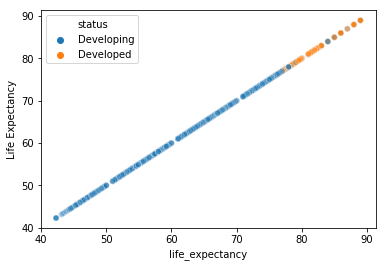

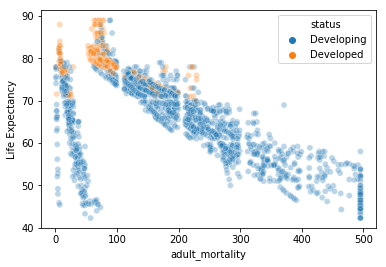

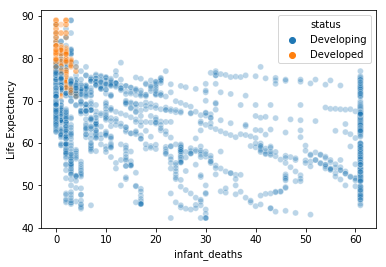

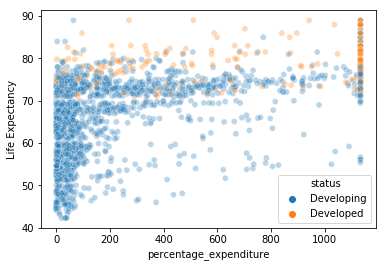

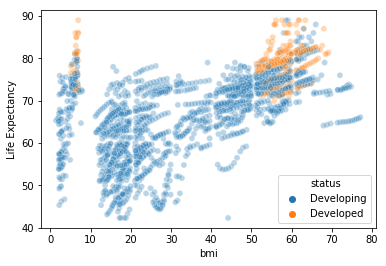

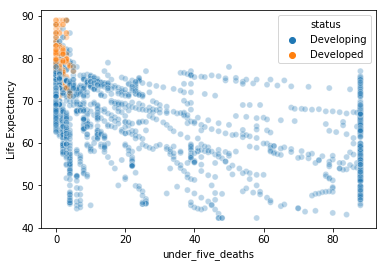

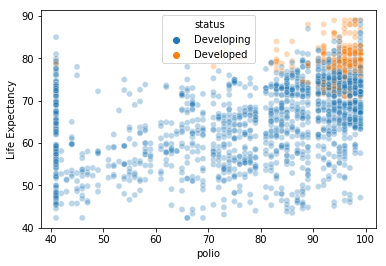

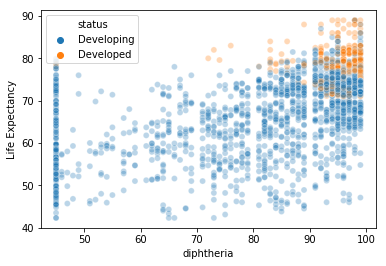

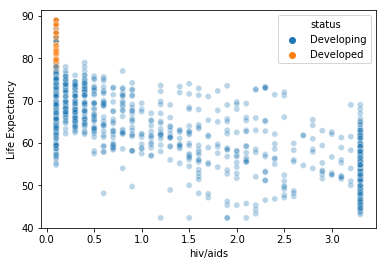

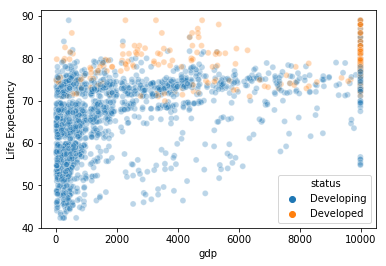

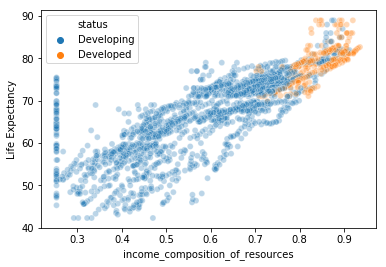

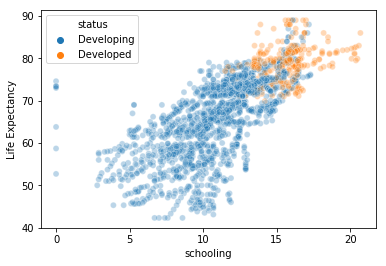

In [16]:
#plot strongest correlations with life expectancy

best_corr_list = []
for col, corr in life_expect_corr.items():
    if (corr > .5) or (corr < -.5):
        best_corr_list.append(col)
        sns.scatterplot(clean_df[col], clean_df['life_expectancy'], alpha=.3,hue=clean_df['status'])
        plt.xlabel(col)
        plt.ylabel('Life Expectancy')
        plt.show()

* In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

In [17]:
clean_df = clean_df[best_corr_list]
clean_df.corr()


,life_expectancy,adult_mortality,infant_deaths,percentage_expenditure,bmi,under_five_deaths,polio,diphtheria,hiv/aids,gdp,income_composition_of_resources,schooling
life_expectancy,1.000000,-0.654901,-0.515853,0.555929,0.600445,-0.548183,0.507473,0.535441,-0.791349,0.549374,0.815499,0.745259
adult_mortality,-0.654901,1.000000,0.302843,-0.313498,-0.384633,0.322271,-0.269296,-0.274523,0.570579,-0.307955,-0.483251,-0.421281
infant_deaths,-0.515853,0.302843,1.000000,-0.366958,-0.475304,0.993697,-0.368139,-0.369402,0.361411,-0.353134,-0.471397,-0.506041
percentage_expenditure,0.555929,-0.313498,-0.366958,1.000000,0.420111,-0.373319,0.281754,0.293506,-0.307407,0.916887,0.625121,0.602386
bmi,0.600445,-0.384633,-0.475304,0.420111,1.000000,-0.494316,0.321270,0.328345,-0.467370,0.432296,0.606020,0.584998
under_five_deaths,-0.548183,0.322271,0.993697,-0.373319,-0.494316,1.000000,-0.388106,-0.390885,0.395138,-0.363880,-0.500032,-0.532101
polio,0.507473,-0.269296,-0.368139,0.281754,0.321270,-0.388106,1.000000,0.827366,-0.417067,0.305333,0.510929,0.518835
diphtheria,0.535441,-0.274523,-0.369402,0.293506,0.328345,-0.390885,0.827366,1.000000,-0.442816,0.315590,0.543053,0.542733
hiv/aids,-0.791349,0.570579,0.361411,-0.307407,-0.467370,0.395138,-0.417067,-0.442816,1.000000,-0.320668,-0.572779,-0.514409
gdp,0.549374,-0.307955,-0.353134,0.916887,0.432296,-0.363880,0.305333,0.315590,-0.320668,1.000000,0.648113,0.619436


Highest correlations features with life expectancy are:
- Income composition of resources
- HIV/AIDS
- Adult mortality
- Schooling

Schooling and income composition of resources correlated well together (.88) so one of the features must be removed from feature list. Since income composition of resources correlate higher than schooling with life expectancy, schooling will be removed. 



In [18]:
feature_df = clean_df[['income_composition_of_resources', 'adult_mortality', 'hiv/aids', 'life_expectancy']]
feature_df

,income_composition_of_resources,adult_mortality,hiv/aids,life_expectancy
0,0.479,263.0,0.1,65.0
1,0.476,271.0,0.1,59.9
2,0.470,268.0,0.1,59.9
3,0.463,272.0,0.1,59.5
4,0.454,275.0,0.1,59.2
5,0.448,279.0,0.1,58.8
6,0.434,281.0,0.1,58.6
7,0.433,287.0,0.1,58.1
8,0.415,295.0,0.1,57.5
9,0.405,295.0,0.1,57.3


In [21]:
#use linear regression with strongest correlated features above
model = LinearRegression(normalize=True)
train_x, test_x, train_y, test_y = train_test_split(feature_df[['income_composition_of_resources', 'adult_mortality', 'hiv/aids']],
                                                    feature_df['life_expectancy'], test_size=.2, shuffle=True)
reg = model.fit(train_x,train_y)

print('Input: {} ... Prediction: {} ... Label {}'.format(sample, reg.predict(sample), label))
print('Model Score: {}'.format(reg.score(test_x,test_y)))


Input: [[4.34e-01 4.95e+02 3.30e+00]] ... Prediction: [50.55445735] ... Label 46.0
Model Score: 0.8417997011394354


In [26]:
#use linear regression with all features to see if above model underfitted compared to using all features
model = LinearRegression(normalize=True)
train_x, test_x, train_y, test_y = train_test_split(feature_df.drop('life_expectancy', axis=1),
                                                    feature_df['life_expectancy'], test_size=.2, shuffle=True)
reg = model.fit(train_x,train_y)

print('Input: {} ... Prediction: {} ... Label {}'.format(sample, reg.predict(sample), label))
print('Model Score: {}'.format(reg.score(test_x,test_y)))

Input: [[4.34e-01 4.95e+02 3.30e+00]] ... Prediction: [50.50808781] ... Label 46.0
Model Score: 0.8458293330794338


Strongest correlated features performed as good as all features model. That's great news if the dataset was larger since using less features would be computationally better. 

In [25]:
#use KNN regressor to compare against linear regression 
#use 
model = KNeighborsRegressor(n_neighbors=3)

train_x, test_x, train_y, test_y = train_test_split(feature_df[['income_composition_of_resources', 'adult_mortality', 'hiv/aids']],
                                                    feature_df['life_expectancy'], test_size=.2, shuffle=True)

knn = model.fit(train_x, train_y)

sample = np.array([0.434,495.0,3.3]).reshape(1,-1)
label = 46.0
print('Input: {} ... Prediction: {} ... Label {}'.format(sample, knn.predict(sample), label))

print('Model Score: {}'.format(knn.score(test_x,test_y)))

Input: [[4.34e-01 4.95e+02 3.30e+00]] ... Prediction: [47.63333333] ... Label 46.0
Model Score: 0.8913120655975919


In [27]:
model = KNeighborsRegressor(n_neighbors=3)

train_x, test_x, train_y, test_y = train_test_split(feature_df.drop('life_expectancy', axis=1),
                                                    feature_df['life_expectancy'], test_size=.2, shuffle=True)

knn = model.fit(train_x, train_y)

sample = np.array([0.434,495.0,3.3]).reshape(1,-1)
label = 46.0
print('Input: {} ... Prediction: {} ... Label {}'.format(sample, knn.predict(sample), label))

print('Model Score: {}'.format(knn.score(test_x,test_y)))

Input: [[4.34e-01 4.95e+02 3.30e+00]] ... Prediction: [47.63333333] ... Label 46.0
Model Score: 0.8920739370479425


* Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

As you can see in the visualization displayed earlier in the notebook, many of the features relating to fatal diseases correlated with life expectancy negatively. The top negative correlation with life expectancy is HIV/AIDS. The close runner ups include: infant deaths, deaths under five years old, and polio. On the flip side, features that revolved around health resources correlated postiviely with life expectancy. The top positive feature is income composition of resources. In both the linear regression and KNN regressor model these top correlated features performed as well as the models used with all features from the dataset. In conclusion, if a country wants to increase it's population overall life expectancy, spending money on increasing schooling and income composition of resources and decreasing HIV/AIds (and obviously decreasing adult mortality) will give the biggest bang for the buck. 